# Preparing the dataset


In [16]:

import torchvision
import os
import json
from PIL import Image

class IDDCocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, annotations, processor, transforms=None):
        super().__init__(img_folder,annFile=annotations, transforms=transforms)
        
        with open(annotations, 'r') as f:
            self.data = json.load(f)
        
        self.img_folder = img_folder
        self.processor = processor
        self.transforms = transforms
        self.images = {img["id"]: img for img in self.data["images"]}
        self.annotations = self._group_annotations_by_image()
        
    def _group_annotations_by_image(self):
        annotations_by_image = {}
        for ann in self.data.get("annotations", []):
            img_id = ann["image_id"]
            if img_id not in annotations_by_image:
                annotations_by_image[img_id] = []
            annotations_by_image[img_id].append(ann)
        return annotations_by_image

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_id = list(self.images.keys())[idx]
        img_info = self.images[image_id]
        img_path = img_info["image_path"]
        img = Image.open(img_path).convert("RGB")
        
        target = {"image_id": image_id, "annotations": self.annotations.get(image_id, [])}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        
        pixel_values = encoding["pixel_values"].squeeze()  # Remove batch dimension
        target = encoding["labels"][0]  # Remove batch dimension
        
        if self.transforms:
            img, target = self.transforms(img, target)
        
        return pixel_values, target


In [17]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset=IDDCocoDetection(img_folder="idd20kII/leftImg8bit", annotations="idd20kII_train_subset.json", processor=processor)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [18]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 100


In [19]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image

Image n°3


{'id': 3,
 'width': 1920,
 'height': 1080,
 'image_path': 'idd20kII/leftImg8bit/train/368/frame0676_leftImg8bit.jpg',
 'license': 1,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': ''}

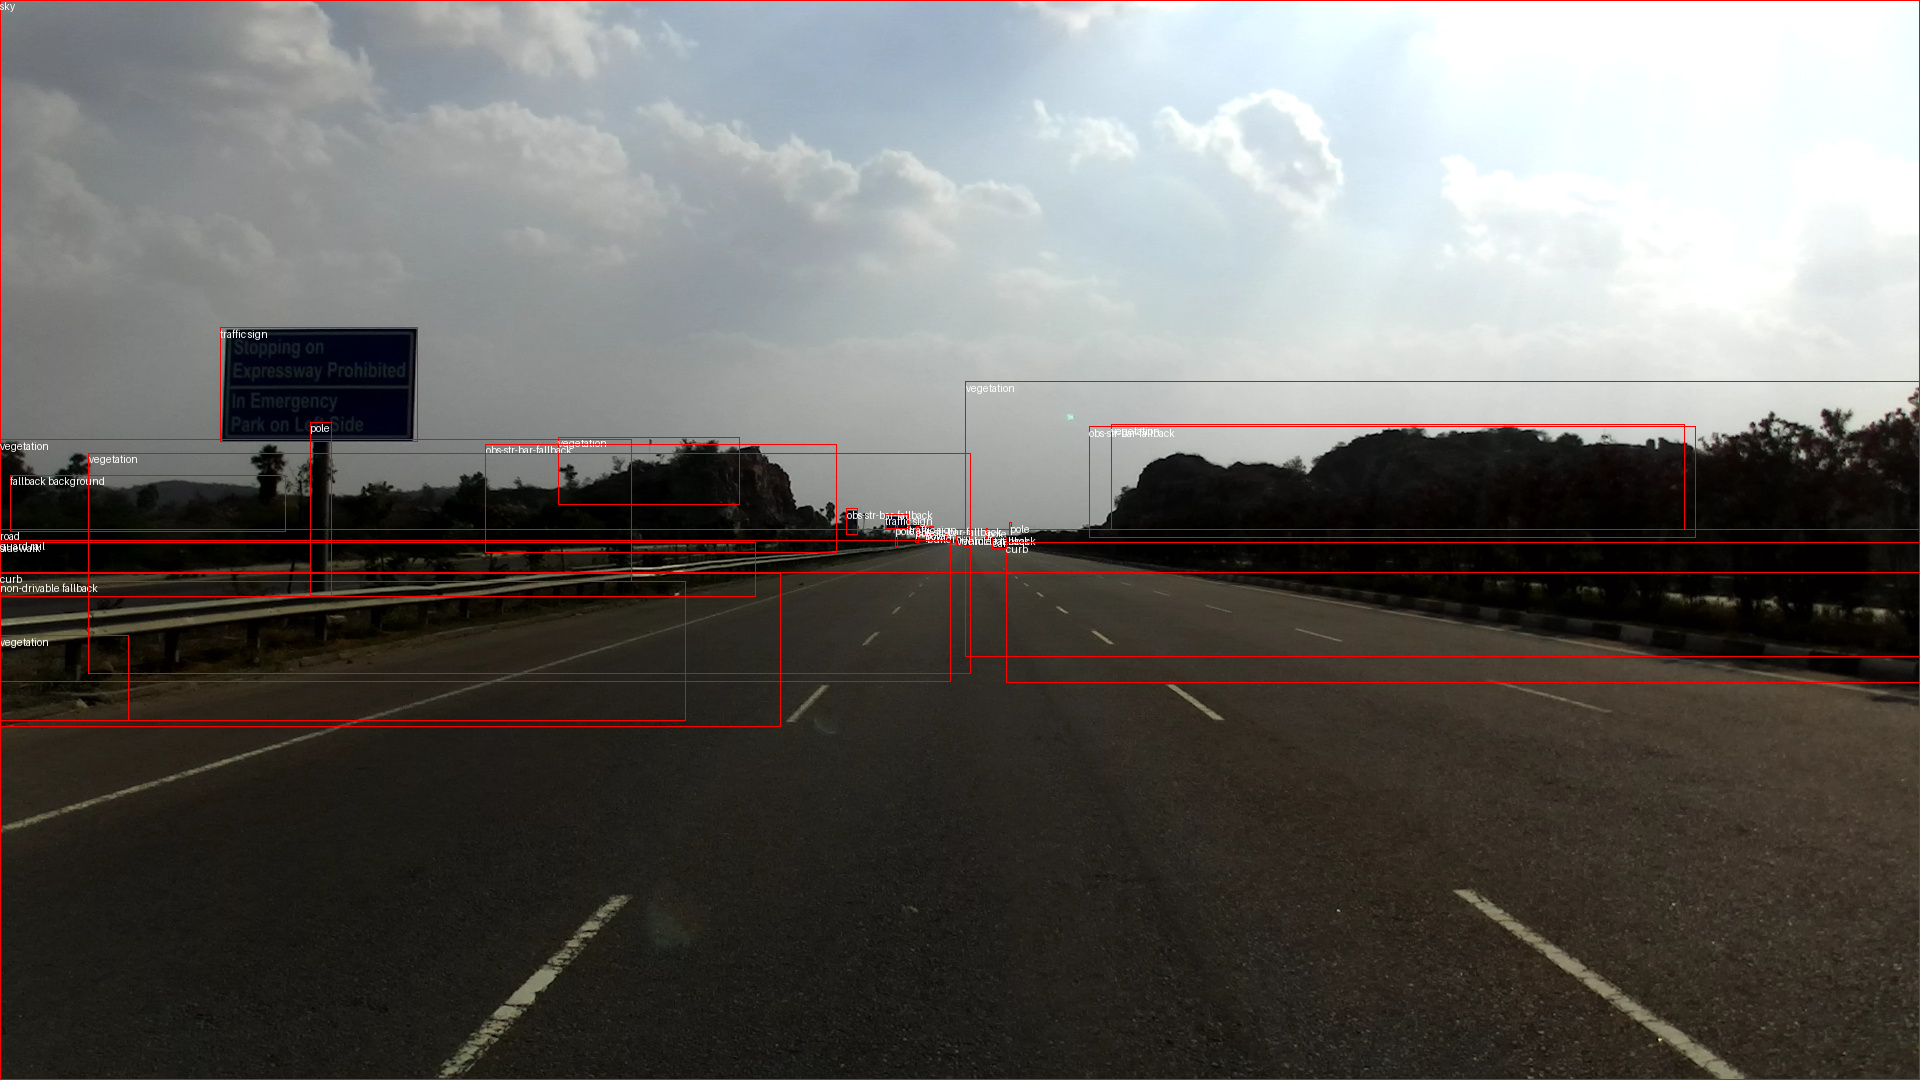

In [20]:
image = Image.open(image['image_path'])

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
#val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [22]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [23]:
pixel_values, target = train_dataset[0]

In [25]:
pixel_values.shape

torch.Size([3, 750, 1333])

In [26]:
print(target)

{'size': tensor([ 750, 1333]), 'image_id': tensor([1]), 'class_labels': tensor([ 1,  2,  3,  3,  4,  4,  4,  4,  5,  4,  4,  4,  4,  6,  6,  7,  5,  7,
         4,  4,  4,  8,  9, 10, 10, 11, 12, 11, 12,  4]), 'boxes': tensor([[0.4997, 0.7516, 0.9995, 0.4949],
        [0.4997, 0.2563, 0.9995, 0.5126],
        [0.2147, 0.6112, 0.4295, 0.1705],
        [0.8275, 0.5304, 0.3440, 0.0523],
        [0.3856, 0.4798, 0.0142, 0.0219],
        [0.3206, 0.4772, 0.0095, 0.0304],
        [0.3110, 0.4594, 0.0222, 0.0684],
        [0.1379, 0.2917, 0.2758, 0.1517],
        [0.1935, 0.4167, 0.3870, 0.3034],
        [0.3771, 0.5134, 0.1941, 0.1357],
        [0.4946, 0.5000, 0.0312, 0.0128],
        [0.6811, 0.4207, 0.0285, 0.0523],
        [0.9100, 0.2799, 0.1790, 0.0675],
        [0.4486, 0.5085, 0.0715, 0.0299],
        [0.1851, 0.5507, 0.3702, 0.0823],
        [0.2506, 0.5775, 0.5012, 0.1506],
        [0.8199, 0.4022, 0.3592, 0.2782],
        [0.8474, 0.5295, 0.3042, 0.0337],
        [0.7544, 0.5000, 

In [27]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader
"""
     def val_dataloader(self):
       return val_dataloader"""

'\n     def val_dataloader(self):\n       return val_dataloader'

In [29]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [30]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([34, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([34]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
outputs.logits.shape

torch.Size([4, 100, 34])

In [32]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/deonx/miniconda3/envs/intel/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
18.1 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.039   Total estimated model params size (MB)
0         Modules in train mode
467       Modules in eval mode
/home/deonx/miniconda3/envs/intel/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value o

Epoch 0:  60%|██████    | 15/25 [00:31<00:21,  0.47it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined